# nn_modeling class

In [26]:
#%%writefile nn_modeling.py
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import ConfusionMatrixDisplay
# imports for neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K


class nn_modeling:

    def __init__(self,model, X_train,X_test,y_train,y_test,group_train,group_test):
        self.X_train=X_train
        self.X_test=X_test
        self.y_train=y_train
        self.y_test=y_test
        self.group_train=group_train
        self.group_test=group_test
        self.model=model
        self.y_pred = None

    # Combine the compilation and training
    def compile_and_train(self, lr=1e-2):
        self.compile_model(lr)
        return self.train_model()

    # compile a model using these specific metrics
    def compile_model(self, lr):
        metrics = [
            keras.metrics.FalseNegatives(name="fn"),
            keras.metrics.FalsePositives(name="fp"),
            keras.metrics.TrueNegatives(name="tn"),
            keras.metrics.TruePositives(name="tp"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
            self.f1,
        ]

        self.model.compile(
            optimizer=keras.optimizers.Adam(lr),
            loss="binary_crossentropy",
            metrics=metrics
        )

    def train_model(self):
        # Use EarlyStopping to prevent overfitting
        early_stopping = keras.callbacks.EarlyStopping(
            patience=10,
            min_delta=0.001,
            restore_best_weights=True,
            mode='max'
        )

        # Calculate the class wheights for the model, improves predictive equality
        class_weights = {0: 1., 1: np.sum(self.y_train == 0) / np.sum(self.y_train == 1)}

        hist = self.model.fit(
                        self.X_train, self.y_train,
                        class_weight=class_weights,batch_size=512,
                        epochs=100, # set lower if you only want to train for short period to get approximat results
                        callbacks=[early_stopping],
                        verbose=1,
                        validation_split=0.1 # Use 10% of training set as validation for EarlyStopping
        )
        # return the training history for possible visualization
        return hist

    # Evaluate a model by passing its output into the evaluate-function
    def score_keras_model(self):
        # Score the test set
        predictions = self.model.predict(self.X_test).flatten()
        self.y_pred = predictions
        self.plot_auc_accuracy_nn()

    def plot_auc_accuracy_nn(self, FIXED_FPR=0.05):
        # Calculating AUC and plotting the ROC Curve
        fpr, tpr, thresholds = roc_curve(self.y_test, self.y_pred)
        roc_auc = roc_auc_score(self.y_test, self.y_pred)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        axes[0].plot(fpr, tpr, color='purple', label='AUC = %0.2f' % roc_auc)
        axes[0].plot([0, 1], [0, 1], color='magenta', linestyle='--')
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')

        # Calculating Accuracy and plotting it
        tpr_fixed_fpr = tpr[fpr < FIXED_FPR][-1]
        fpr_fixed_fpr = fpr[fpr < FIXED_FPR][-1]
        threshold_fixed_fpr = thresholds[fpr < FIXED_FPR][-1]

        print("AUC:", roc_auc)
        to_pct = lambda x: str(round(x, 4) * 100) + "%"
        print("TPR: ", to_pct(tpr_fixed_fpr), "\nFPR: ", to_pct(fpr_fixed_fpr), "\nThreshold: ", round(threshold_fixed_fpr, 2))

        # Calling get_fairness_metrics to calculate predictive equality
        predictive_equality, disparities_df = self.get_fairness_metrics_nn(self.group_test,self.y_test,self.y_pred, FIXED_FPR)
        print("Predictive Equality: ", to_pct(predictive_equality))

        # extract the predicted class labels
        thresh = round(threshold_fixed_fpr, 2)
        predictions = np.where(self.y_pred > thresh, 1, 0) # or use the threshold instead of 0.5?

        accuracy = accuracy_score(y_test, predictions)
        axes[1].bar(['Accuracy'], [accuracy], color=['purple'])
        axes[1].set_ylim([0, 1.5])
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('Accuracy')
        axes[1].set_xticks([])
        axes[1].tick_params(axis='y', labelsize=10)

        # Add accuracy value as text label on the accuracy bar plot
        axes[1].text(0, accuracy + 0.05, '{:.2f}'.format(accuracy), horizontalalignment='center', fontsize=15)
        # Adjusting the layout of the subplots and displaying the plot
        fig.tight_layout()
        plt.show()

        #ConfusionMatrixDisplay.from_predictions(y_test, predictions)
        self.plot_confmat_classreport_nn(predictions)
        print(classification_report(self.y_test, predictions))


    def get_fairness_metrics_nn(self,groups,y_true, y_pred,FIXED_FPR=0.05):
        labels = self.y_test
        groups = self.group_test
        g = Group()
        aequitas_df = pd.DataFrame(
            {"score": y_pred,
             "label_value": y_true,
             "group": groups}
        )

        # Use aequitas to compute confusion matrix metrics for every group.
        disparities_df = g.get_crosstabs(aequitas_df, score_thresholds={"score_val": [FIXED_FPR]})[0]

        # Predictive equality is the differences in FPR (we use ratios in the paper)
        predictive_equality = disparities_df["fpr"].min() / disparities_df["fpr"].max()
        return predictive_equality, disparities_df


    def plot_confmat_classreport_nn(self, predictions):

        # Calculating Confusion Matrix and plotting it
        CM = confusion_matrix(self.y_test, predictions)
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
        sns.heatmap(CM, annot=True, fmt='g', cmap='Pastel1', ax=axes)
        axes.set_xlabel('Predicted')
        axes.set_ylabel('Truth')
        axes.set_title('Confusion Matrix')

        # Adjusting the layout of the subplots and displaying the plot
        fig.tight_layout()
        plt.show()

    def f1(self, y_true, y_pred): #taken from old keras source code
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())
        f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
        return f1_val

    # --- Two currently unused metrics ---
    def recall(self, y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def focal_loss(self, gamma=2., alpha=.25):
        def focal_loss_fixed(y_true, y_pred):
            pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
            pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
            return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
        return focal_loss_fixed

    def save_model(self,filename):
        # Save the model to disk using pickle
        with open(filename, 'wb') as f:
            pickle.dump(self.model, f)

        # Return the path to the saved model file
        return filename


Writing nn_modeling.py


# Colab Setup

Installing Needed Requirements

In [1]:
! pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 45.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for association_metrics: filename=association_metrics-0.0.1-py3-none-any.whl size=3930 sha256=7cf3ae533047e8257458025e7133de52414c0d1e5850bca1e1c6f2ff7de2471e
  Stored in directory: /root/.cache/pip/wheels/01/47/5f/4

Importing Data from Kaggle

In [1]:
from google.colab import files
files.upload()

! pip install -q kaggle
! mkdir ~/.kaggle # making new directory
! cp kaggle.json ~/.kaggle/ # copying kaggle json file to the created directory
! chmod 600 ~/.kaggle/kaggle.json # changing the permissions
! kaggle datasets download -d sgpjesus/bank-account-fraud-dataset-neurips-2022 # downloading the dataset
! mkdir data # making new directory on colab session to unzip the dataset in it
! unzip -q bank-account-fraud-dataset-neurips-2022.zip -d data # unzipping the downloaded data

Saving kaggle.json to kaggle.json
100% 545M/546M [00:30<00:00, 24.8MB/s]
100% 546M/546M [00:30<00:00, 18.7MB/s]


# loading the classes

In [2]:
from data_cleaning import *
from modeling import *
from preprocessing import *

# Splitting the data

In [4]:
def split_data(df,criteria='random'):
    X = df.drop(['fraud_bool'], axis=1)
    y = df['fraud_bool']
    if criteria=='paper':

        # Train test split by 'month', month 0-5 are train, 6-7 are test data as proposed in the paper
        X_train = X[X['month']<6]
        X_test = X[X['month']>=6]
        y_train = y[X['month']<6]
        y_test = y[X['month']>=6]


    elif criteria=='random':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    elif criteria=='stratify':

        X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, random_state=42)

    X_train.drop('month', axis=1, inplace=True)
    X_test.drop('month', axis=1, inplace=True)
    return X_train, X_test, y_train, y_test

# reading the data

In [5]:
df=data_cleaning('/content/data/Base.csv').get_data()

In [6]:
# split the data
X_train, X_test, y_train, y_test=split_data(df,criteria= 'paper')

# getting the groups:

In [7]:
train_groups=(X_train["customer_age"] > 50).map({True: ">50", False: "<=50"})
test_groups=(X_test["customer_age"] > 50).map({True: ">50", False: "<=50"})

# start the preprocessing

In [8]:
data = preprocessing(X_train, y_train)


# Scaling numerical features:

In [9]:
scalers = {}
for column in X_train.select_dtypes(include=['int','float']):
    m,scaler=data.scale_data('standard',column)
    scalers[column] = scaler

In [10]:
# apply the same scaling on the testset
for column in X_test.select_dtypes(include=['int','float']):
    X_test[column] = scalers[column].transform(X_test[[column]])

# encode the categorical features

In [11]:
encoders = {}
for column in X_train.select_dtypes(include=['category','object']):
    _, encoder = data.encode_categorical_features(column , encoding_type= 'one-hot')
    encoders[column] = encoder

In [12]:
# apply the encoding on the testset
for column in X_test.select_dtypes(include=['object','category']).columns:
    ohe=encoders[column]
    encoded_col = pd.DataFrame(ohe.transform(X_test[column].values.reshape(-1, 1)).toarray(),index=X_test.index)
    encoded_col.columns = [column + '_' + str(val) for val in ohe.categories_[0]]
    X_test = pd.concat([X_test, encoded_col], axis=1)
    X_test.drop(columns=column, inplace=True,axis=1)

In [13]:
# arrange the column names according to the concat data
X_test=X_test[data.concat_data().columns]

In [14]:
X_train,y_train=data.get_data()

# modeling : training and evaluation

In [21]:
# Keras model using dropout and batch normalization
nn_model2 = keras.Sequential([
    keras.layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

In [22]:
experiment=nn_modeling(nn_model2, X_train,X_test,y_train,y_test,train_groups,test_groups)

In [23]:
%%time
hist = experiment.compile_and_train(lr = 1e-2)

Epoch 1/100
1398/1398 [==============================] - 20s 10ms/step - loss: 1.0744 - fn: 1721.0000 - fp: 182285.0000 - tn: 525054.0000 - tp: 6430.0000 - precision: 0.0341 - recall: 0.7889 - f1: 0.0702 - val_loss: 0.6498 - val_fn: 0.0000e+00 - val_fp: 26880.0000 - val_tn: 52619.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/100
1398/1398 [==============================] - 13s 9ms/step - loss: 0.9947 - fn: 1602.0000 - fp: 154510.0000 - tn: 552829.0000 - tp: 6549.0000 - precision: 0.0407 - recall: 0.8035 - f1: 0.0785 - val_loss: 0.5090 - val_fn: 0.0000e+00 - val_fp: 20358.0000 - val_tn: 59141.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/100
1398/1398 [==============================] - 12s 9ms/step - loss: 0.9837 - fn: 1618.0000 - fp: 150529.0000 - tn: 556810.0000 - tp: 6533.0000 - precision: 0.0416 - recall: 0.8015 - f1: 0.0803 - val_loss: 0.4698 - val_fn: 0.0000e

6407/6407 [==============================] - 13s 2ms/step
AUC: 0.878653319745883
TPR:  50.029999999999994% 
FPR:  5.0% 
Threshold:  0.86
Predictive Equality:  89.28%


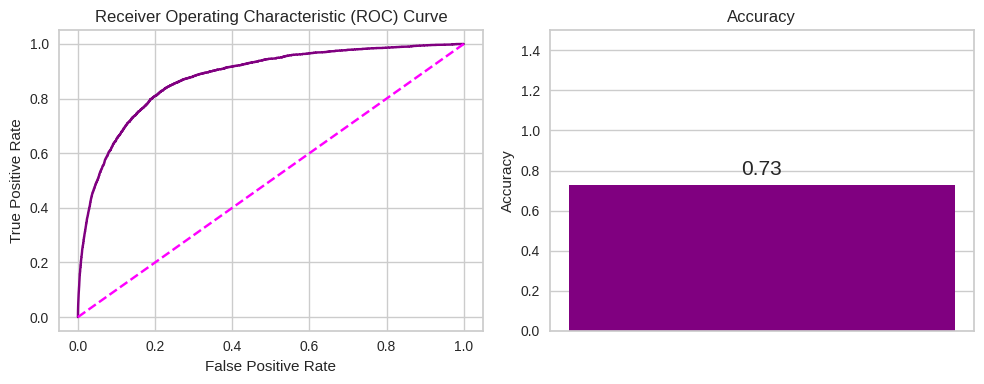

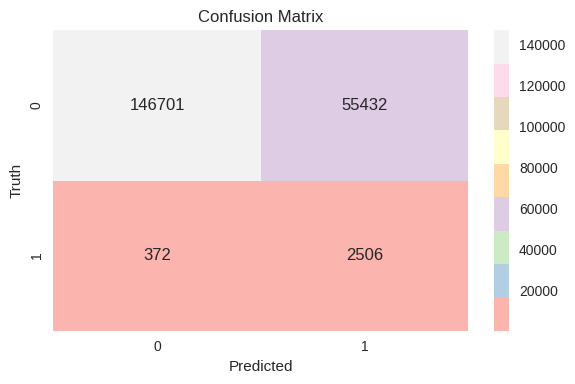

              precision    recall  f1-score   support

           0       1.00      0.73      0.84    202133
           1       0.04      0.87      0.08      2878

    accuracy                           0.73    205011
   macro avg       0.52      0.80      0.46    205011
weighted avg       0.98      0.73      0.83    205011



In [24]:
experiment.score_keras_model()

In [25]:
# Save the best model
saved_model_path = experiment.save_model('nn_model.h5')
print("Model saved at:", saved_model_path)

TypeError: ignored